## SQuAD 2.0

Reading comprehension/information retrieval models are the building blocks of chatbots that a lot of businesses are leveraging primarily for customer service. 

The Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions on a set of Wikipedia articles, where the answer to answerable questions (there are questions that are impossible to answer with the information provided) is a segment or span within the corresponding reading passage. The objective is to build Neural Networks that will be able to predict the span of the answer within the corresponding passage or context. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

# import nltk
# import re
# import gensim.models.word2vec as w2v
# import sklearn.manifold
# import glob
from tqdm import tqdm
# from functools import reduce

from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, RepeatVector, Flatten, recurrent, LSTM, Concatenate, merge
from keras.layers import Input, Bidirectional, RNN, GRU, Activation
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
# from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
# from IPython.display import SVG
from keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam, RMSprop, SGD, TFOptimizer
# from keras.utils.vis_utils import model_to_dot
# from sklearn.preprocessing import LabelEncoder
from numpy.random import seed
import tensorflow as tf

seed(42)
%matplotlib inline

Using TensorFlow backend.


### Load in JSON File

In [2]:
train = pd.read_json('./data/train-v2.0.json')
test = pd.read_json('./data/dev-v2.0.json')

In [3]:
# train["data"][0]

In [4]:
# train_topics = []
# for aid in tqdm(range(len(train["data"]))):
#     topic = train["data"][aid]["title"]
#     train_topics.append(topic)
    
# print(len(train_topics))

In [5]:
# test_topics = []
# for aid in tqdm(range(len(test["data"]))):
#     topic = test["data"][aid]["title"]
#     test_topics.append(topic)
    
# print(len(test_topics))

In [6]:
#extract data from train JSON file to dictionary

train_dict = {"contexts": [], "questions": [], "answers": [], "answer_starts": []}

for aid in tqdm(range(len(train["data"]))):
    articles = train["data"][aid]["paragraphs"]
    for pid in range(len(articles)):
        qas = articles[pid]["qas"]
        for qid in range(len(qas)):
            if qas[qid]["is_impossible"] == False:
                context = articles[pid]["context"]
                train_dict["contexts"].append(context)
                question = qas[qid]["question"]
                train_dict["questions"].append(question)
                answer_text = qas[qid]["answers"]
                for a in answer_text:
                    answer_start = a["answer_start"]
                    train_dict["answer_starts"].append(answer_start)
                    answer = a["text"]
                    train_dict["answers"].append(answer)
#                     answer_end = answer_start + len(answer)
#                     train_dict["answer_ends"].append(answer_end)
                    

100%|██████████| 442/442 [00:00<00:00, 3099.88it/s]


In [7]:
#extract data from development/test JSON file to dictionary

test_dict = {"contexts": [], "questions": [], "answers": [], "answer_starts": []}

for aid in tqdm(range(len(test["data"]))):
    articles = test["data"][aid]["paragraphs"]
    for pid in range(len(articles)):
        qas = articles[pid]["qas"]
        for qid in range(len(qas)):
            if qas[qid]["is_impossible"] == False:
                context = articles[pid]["context"]
                test_dict["contexts"].append(context)
                question = qas[qid]["question"]
                test_dict["questions"].append(question)
                answer_text = qas[qid]["answers"][0]
                answer_start = answer_text["answer_start"]
                test_dict["answer_starts"].append(answer_start)
                answer = answer_text["text"]
                test_dict["answers"].append(answer)
#                 answer_end = answer_start + len(answer)
#                 test_dict["answer_ends"].append(answer_end)

100%|██████████| 35/35 [00:00<00:00, 2978.43it/s]


In [8]:
train_df = pd.DataFrame(train_dict)
test_df = pd.DataFrame(test_dict)

In [9]:
print(train_df.shape)
print(test_df.shape)

(86821, 4)
(5928, 4)


In [10]:
train_df.head()

,contexts,questions,answers,answer_starts
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276


In [11]:
test_df.head()

,contexts,questions,answers,answer_starts
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,159
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,94
2,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256
3,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,308
4,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,10th century,671


##### SQuAD Dataset

Issues with Dataset:
  1. Some answers don't exactly match what's in the context.
  2. One word answers appear in multiple locations.

For the first iteration of this project, answers that did not exactly match what was in the context and were one word were removed.


### Preprocessing before modeling

In [12]:
#remove punctuation and set everything to lowercase on train dataframe

# for i in tqdm(train_df.select_dtypes(include=object).columns):
#     train_df[i] = train_df[i].str.replace("[^\w\s]",'')
#     train_df[i] = train_df[i].map(lambda x: x.lower())

In [13]:
#remove punctuation and set everything to lowercase on test dataframe

# for i in tqdm(test_df.select_dtypes(include=object).columns):
#     test_df[i] = test_df[i].str.replace("[^\w\s]",'')
#     test_df[i] = test_df[i].map(lambda x: x.lower())

In [14]:
#text_to_word_sequence on a copy of train dataframe to find the max len of each text column for padding

train_df_tk = train_df.copy()
for i in tqdm(train_df.select_dtypes(include=object).columns):
    train_df_tk[i] = train_df_tk[i].map(lambda x: text_to_word_sequence(x))

100%|██████████| 3/3 [00:06<00:00,  2.88s/it]


In [15]:
# text_to_word_sequence on a copy of test dataframe to find the max len of each text column for padding

test_df_tk = test_df.copy()
for i in tqdm(test_df.select_dtypes(include=object).columns):
    test_df_tk[i] = test_df_tk[i].map(lambda x: text_to_word_sequence(x))

100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


In [16]:
test_df_tk.head()

,contexts,questions,answers,answer_starts
0,"[the, normans, norman, nourmands, french, norm...","[in, what, country, is, normandy, located]",[france],159
1,"[the, normans, norman, nourmands, french, norm...","[when, were, the, normans, in, normandy]","[10th, and, 11th, centuries]",94
2,"[the, normans, norman, nourmands, french, norm...","[from, which, countries, did, the, norse, orig...","[denmark, iceland, and, norway]",256
3,"[the, normans, norman, nourmands, french, norm...","[who, was, the, norse, leader]",[rollo],308
4,"[the, normans, norman, nourmands, french, norm...","[what, century, did, the, normans, first, gain...","[10th, century]",671


In [17]:
#function returns the start and end token indices of answers within the document
#takes in the document and answers as a list of tokens

def find_startend_index(list_of_words, answer):
        len_ans = len(answer)
        list_of_words.append("")
        start_idx = [idx for idx,w in enumerate(list_of_words[:(-1*len_ans)]) if w == answer[0] and list_of_words[idx + (len_ans -1)] == answer[-1]]
#         print(start_idx)
#         if len(start_idx) != 1:
#             print(start_idx)
#             print(answer)
#             print(list_of_words)
        if len(start_idx) > 0 and len(start_idx) < 2:
            end_idx = start_idx[0] + (len_ans -1)
            return start_idx[0], end_idx     
        else:
            return None, None

In [18]:
train_word_idx = {"start_idx": [], "end_idx": []}
for i in tqdm(range(len(train_df_tk["contexts"]))):
    start_idx, end_idx = find_startend_index(train_df_tk["contexts"][i], train_df_tk["answers"][i])
    if start_idx == None  and end_idx == None:
        train_word_idx["start_idx"].append(None)
        train_word_idx["end_idx"].append(None)
    else:
        train_word_idx["start_idx"].append(int(start_idx))
        train_word_idx["end_idx"].append(int(end_idx))

100%|██████████| 86821/86821 [00:03<00:00, 26420.45it/s]


In [19]:
test_word_idx = {"start_idx": [], "end_idx": []}
for i in tqdm(range(len(test_df_tk["contexts"]))):
    start_idx, end_idx = find_startend_index(test_df_tk["contexts"][i], test_df_tk["answers"][i])
    if start_idx == None and end_idx == None:
        test_word_idx["start_idx"].append(None)
        test_word_idx["end_idx"].append(None)
    else:
        test_word_idx["start_idx"].append(int(start_idx))
        test_word_idx["end_idx"].append(int(end_idx))

100%|██████████| 5928/5928 [00:00<00:00, 23733.75it/s]


In [20]:
train_idx_df = pd.DataFrame(train_word_idx)
test_idx_df = pd.DataFrame(test_word_idx)

In [21]:
#concat start/end index dataframe with original

train_df_tk = pd.concat([train_df_tk, train_idx_df], axis=1)
test_df_tk = pd.concat([test_df_tk, test_idx_df], axis=1)

In [22]:
#drop rows where answers don't match exactly what's in the context

train_df_tk.dropna(inplace = True)
test_df_tk.dropna(inplace = True)

In [23]:
train_df_tk.reset_index(inplace=True)
test_df_tk.reset_index(inplace=True)

In [24]:
train_df_tk[train_df_tk["start_idx"].isnull()]

,index,contexts,questions,answers,answer_starts,start_idx,end_idx


In [25]:
len(train_df_tk["start_idx"])

75578

In [26]:
con_len = []
for i in tqdm(range(len(train_df_tk["start_idx"]))):
    con_len.append(len(train_df_tk["contexts"][i]))

100%|██████████| 75578/75578 [00:01<00:00, 74226.53it/s]


In [27]:
con_len_test = []
for i in tqdm(range(len(test_df_tk["start_idx"]))):
    con_len_test.append(len(test_df_tk["contexts"][i]))

100%|██████████| 5059/5059 [00:00<00:00, 59815.26it/s]


In [28]:
train_df_tk["context_length"] = con_len
test_df_tk["context_length"] = con_len_test

In [29]:
train_df_tk[train_df_tk["context_length"] < train_df_tk["start_idx"]]

,index,contexts,questions,answers,answer_starts,start_idx,end_idx,context_length


In [30]:
test_df_tk[test_df_tk["context_length"] < test_df_tk["start_idx"]]

,index,contexts,questions,answers,answer_starts,start_idx,end_idx,context_length


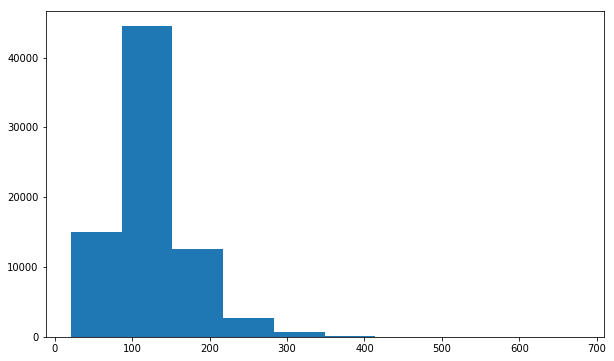

In [31]:
plt.figure(figsize=(10,6))
plt.hist(train_df_tk["context_length"]);

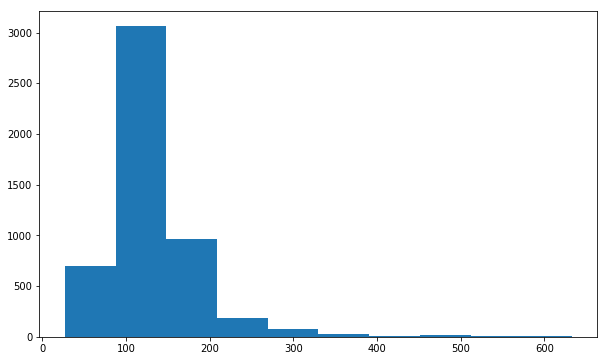

In [32]:
plt.figure(figsize=(10,6))
plt.hist(test_df_tk["context_length"]);

In [33]:
q_len = []
for i in tqdm(range(len(train_df_tk["start_idx"]))):
    q_len.append(len(train_df_tk["questions"][i]))

100%|██████████| 75578/75578 [00:01<00:00, 72553.81it/s]


In [34]:
q_len_test = []
for i in tqdm(range(len(test_df_tk["start_idx"]))):
    q_len_test.append(len(test_df_tk["questions"][i]))

100%|██████████| 5059/5059 [00:00<00:00, 66479.05it/s]


In [35]:
train_df_tk["question_length"] = q_len
test_df_tk["question_length"] = q_len_test

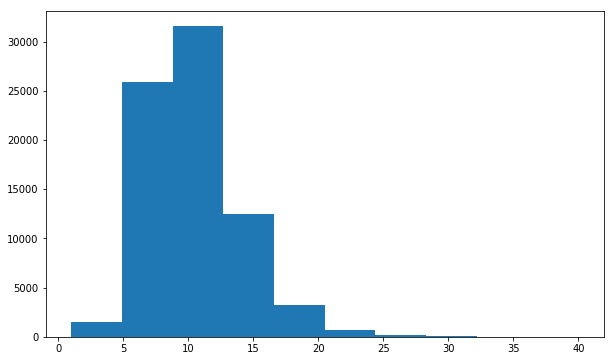

In [36]:
plt.figure(figsize=(10,6))
plt.hist(train_df_tk["question_length"]);

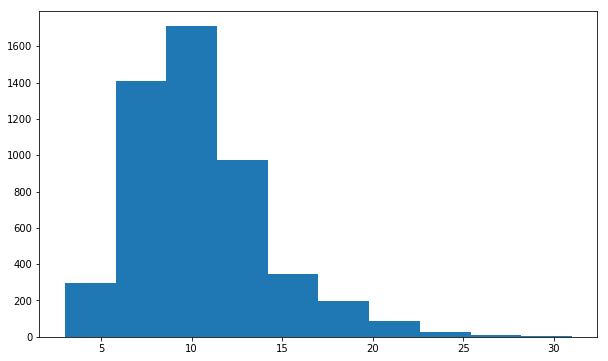

In [37]:
plt.figure(figsize=(10,6))
plt.hist(test_df_tk["question_length"]);

In [38]:
print(len(train_df_tk[train_df_tk["context_length"] <= 200]) / len(train_df_tk["context_length"]))
print(len(train_df_tk[train_df_tk["context_length"] <= 200]))
print(len(train_df_tk["context_length"]))

0.9306147291539866
70334
75578


In [39]:
print(len(train_df_tk[train_df_tk["question_length"] <= 20]) / len(train_df_tk["question_length"]))
print(len(train_df_tk[train_df_tk["question_length"] <= 20]))
print(len(train_df_tk["question_length"]))

0.9887401095556908
74727
75578


In [40]:
print(len(test_df_tk[test_df_tk["context_length"] <= 200]) / len(test_df_tk["context_length"]))
print(len(test_df_tk[test_df_tk["context_length"] <= 200]))
print(len(test_df_tk["context_length"]))

0.9163866376754299
4636
5059


In [41]:
print(len(test_df_tk[test_df_tk["question_length"] <= 20]) / len(test_df_tk["question_length"]))
print(len(test_df_tk[test_df_tk["question_length"] <= 20]))
print(len(test_df_tk["question_length"]))

0.9839889306186993
4978
5059


In [42]:
train_df_tk = train_df_tk[train_df_tk["context_length"] <= 200]
test_df_tk = test_df_tk[test_df_tk["context_length"] <= 200]

In [43]:
train_df_tk = train_df_tk[train_df_tk["question_length"] <= 20]
test_df_tk = test_df_tk[test_df_tk["question_length"] <= 20]

In [44]:
train_df_tk.reset_index(inplace=True)
test_df_tk.reset_index(inplace=True)

In [45]:
drop_list = ["level_0", "index"]

train_df_tk = train_df_tk.drop(drop_list, axis=1)
test_df_tk = test_df_tk.drop(drop_list, axis=1)

In [46]:
print(train_df_tk.shape)
print(test_df_tk.shape)

(69542, 8)
(4570, 8)


#### Set Variables

In [47]:
Xc_sr = train_df_tk["contexts"]
Xq_sr = train_df_tk["questions"]
y_sr = train_df["answers"]
ys_sr = train_df_tk["start_idx"]
ye_sr = train_df_tk["end_idx"]

Xc_test_sr = test_df_tk["contexts"]
Xq_test_sr = test_df_tk["questions"]
y_test_sr = test_df["answers"]
ys_test_sr = test_df_tk["start_idx"]
ye_test_sr = test_df_tk["end_idx"]

In [48]:
#concat the contexts and questions vertically to get a full vocabulary list.

total = pd.concat([Xc_sr, Xq_sr, Xc_test_sr, Xq_test_sr], axis = 0)

In [49]:
#tokenize the concat corpuses to get the unique vocab list from tk.word_index

#check TK to see if this is the f'ing issue.
tk = Tokenizer()
tk.fit_on_texts(total)
tk_train_seq = tk.texts_to_sequences(total)

In [50]:
len(tk.word_index)

87442

In [51]:
NB_WORDS = len(tk.word_index)  #Number of unique words in vocabulary dictionary
MAX_LEN_C = len(max(Xc_sr, key=len)) #Maximum number of words in context
MAX_LEN_Q = len(max(Xq_sr, key=len)) #Maximum number of words in question

In [52]:
print("MAX_LEN_C: ", MAX_LEN_C)
print("MAX_LEN_Q: ", MAX_LEN_Q)

MAX_LEN_C:  200
MAX_LEN_Q:  20


In [53]:
#function to tokenize a corpus
#takes in the corpus, unique vocabulary size, max len for padding, tokenizer

def tokenize_text(text, num_words, max_len, tk):
#     tk = Tokenizer(num_words=num_words)
#     tk.fit_on_texts(text)
    text_seq = tk.texts_to_sequences(text)
    text_seq_pad = pad_sequences(text_seq, maxlen=max_len)
    return text_seq_pad

In [54]:
Xc_train = tokenize_text(Xc_sr, NB_WORDS, MAX_LEN_C, tk)
Xq_train = tokenize_text(Xq_sr, NB_WORDS, MAX_LEN_Q, tk)

Xc_test = tokenize_text(Xc_test_sr, NB_WORDS, MAX_LEN_C, tk)
Xq_test = tokenize_text(Xq_test_sr, NB_WORDS, MAX_LEN_Q, tk)

In [55]:
y_array_train = np.zeros((len(train_df_tk["start_idx"]), MAX_LEN_C))
for i in tqdm(range(len(y_array_train))):
    idx = int(MAX_LEN_C - len(train_df_tk["contexts"][i]) + train_df_tk["start_idx"][i] - 1)
    y_array_train[i][idx] = 1


100%|██████████| 69542/69542 [00:01<00:00, 34871.12it/s]


In [56]:
y_array_test = np.zeros((len(test_df_tk["start_idx"]), MAX_LEN_C))
for i in tqdm(range(len(y_array_test))):
    idx = int(MAX_LEN_C - len(test_df_tk["contexts"][i]) + test_df_tk["start_idx"][i] - 1)
    y_array_test[i][idx] = 1

100%|██████████| 4570/4570 [00:00<00:00, 30192.10it/s]


### GloVe Embedding

https://nlp.stanford.edu/projects/glove/

In [57]:
# Create a dictionary of words to word vectors.

GLOVE_DIM = 300

glove_file = 'glove.6B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open('./data/' + glove_file)
for line in tqdm(glove):
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

400000it [00:23, 16702.99it/s]


In [58]:
#create an embedding matrix based on the pretrained GloVe word vectors
#use embedding matrix as weights in the embedding layer of Neural Network

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tqdm(tk.word_index.items()):
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
#     else:
#         continue

100%|██████████| 87442/87442 [00:00<00:00, 208297.48it/s]


In [59]:
# #function that replaces words in corpus with pretrained GloVe word vectors

# def text_to_glove(text):
#     glove = text.copy()
#     for j, line in tqdm(enumerate(text)):
#         for i in range(len(line)):
#             vect = emb_dict.get(line[i])
#             if type(vect) != None:
#                 glove[j][i] = vect
#             else:
#                 glove[j][i] = np.zeros((1, 300))  
#     return glove


### Model 1 - GloVe Embedding

In [60]:
GLOVE_DIM = 300
BATCH_SIZE = 32
EPOCHS = 50
NB_WORDS = len(tk.word_index)

In [61]:
#inputs
context_input = Input(shape=(MAX_LEN_C,), name="context_input")
question_input = Input(shape=(MAX_LEN_Q,), name="question_input")

#embedding layers with emb matrix weights based of pre-trained GloVe word vectors
context_embedding_layer = Embedding(NB_WORDS, 300, weights=[emb_matrix], input_length=MAX_LEN_C, 
                                    trainable=False)(context_input)

question_embedding_layer = Embedding(NB_WORDS,300, weights=[emb_matrix], input_length=MAX_LEN_Q, 
                                     trainable=False)(question_input)

# context_embedded_sequences = context_embedding_layer(context_input)
# question_embedded_sequences = question_embedding_layer(question_input)

#First read question, then read context conditioned on question output
#hidden state (h_state) and cell state (c_state) of question LSTM layer passed into context LSTM layer
question_encoder, h_left, c_left, h_right, c_right = Bidirectional(LSTM(8, return_state=True, dropout=0.35))(question_embedding_layer)
context_encoder = Bidirectional(LSTM(8, dropout=0.35))(context_embedding_layer, initial_state=[h_left, h_right, c_left, c_right])


intermediate = Dense(MAX_LEN_C, activation='relu')(context_encoder)
intermediate = Dropout(0.35)(intermediate)
intermediate = Dense(MAX_LEN_C, activation='relu')(intermediate)
predictions = Dense(MAX_LEN_C,activation='softmax', name='output')(intermediate)
model = Model(inputs=[context_input,question_input],outputs=predictions)

# optimizer = SGD(lr=0.05)
optimizer = Adam(lr=0.001)
# optimizer = Adadelta(lr=0.1)
# optimizer = Adagrad(lr=0.1)
# optimizer = Adamax(lr=0.1)
# optimizer = Nadam(lr=0.1)
# optimizer = RMSprop(lr=0.1)


model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 300)      26232600    question_input[0][0]             
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     26232600    context_input[0][0]              
__________________________________________________________________________________________________
bidirectio

In [62]:
plot_model(model, to_file='model.png')

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
              baseline=None, restore_best_weights=False)

In [ ]:
history = model.fit({'context_input':Xc_train,'question_input':Xq_train},{'output':y_array_train},
          epochs=20, batch_size=BATCH_SIZE, validation_split = 0.3, callbacks = [early_stopping])

In [ ]:
model.evaluate([Xc_test, Xq_test], y_array_test, batch_size=BATCH_SIZE)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val_Loss")
plt.legend()

In [ ]:
predictions = model.predict([Xc_test, Xq_test])

In [ ]:
len(predictions)

In [ ]:
predictions[0]

In [ ]:
predictions[0].argmax()

### Word2Vec Embedding

In [ ]:
# %%time 

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
#     level=logging.INFO)

# # Set values for various parameters
# VEC_DIM = 300    # Word vector dimensionality                      
# MIN_COUNT = 40   # Minimum word count                        
# WORKERS = 4     # Number of threads to run in parallel
# WINDOW = 10    # Context window size                                                                                    
# DOWN = 1e-3   # Downsample setting for frequent words

# from gensim.models import word2vec
# print("Training model...")

# #Context
# Xc = word2vec.Word2Vec(X, workers=WORKERS,
#             size=VEC_DIM, min_count = MIN_COUNT,
#             window = WINDOW, sample = DOWN)

# #Questions
# Xq = word2vec.Word2Vec(Xq, workers=WORKERS,
#             size=VEC_DIM, min_count = MIN_COUNT,
#             window = WINDOW, sample = DOWN)